⚠️ 파일 없음: ./data/PS_1773K_NOS_C7H8.csv, 건너뜁니다.
⚠️ 파일 없음: ./data/PS_2773K_NOS_C7H8.csv, 건너뜁니다.


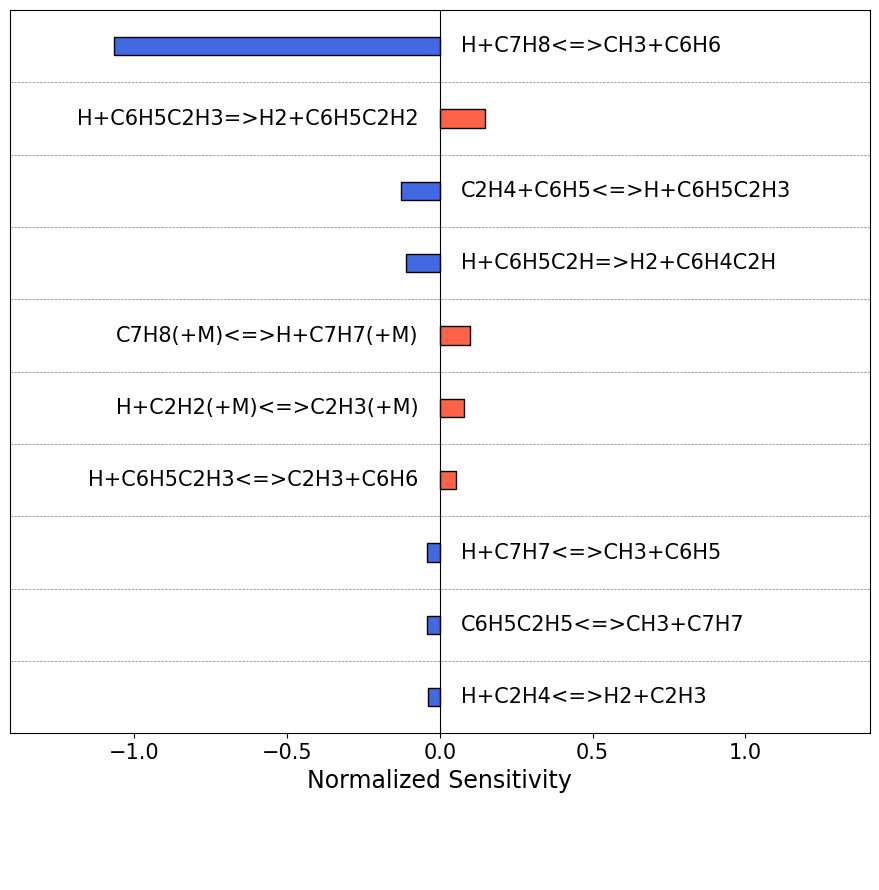

In [5]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

# === 반반 색 범례용 클래스 & 핸들러 ===
class SplitLegend(mpatches.Rectangle):
    """좌/우 반반 색상을 가진 범례 핸들(실제 Patch)"""
    def __init__(self, color_left="navy", color_right="firebrick"):
        super().__init__((0, 0), 1, 1, facecolor="none", edgecolor="black")
        self._color_left = color_left
        self._color_right = color_right

class HandlerSplit(HandlerPatch):
    """SplitLegend를 범례에서 좌/우 두 색 사각형으로 그려주는 핸들러"""
    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        cl = getattr(orig_handle, "_color_left", "gray")
        cr = getattr(orig_handle, "_color_right", "lightgray")
        left = mpatches.Rectangle([xdescent, ydescent], width/2, height,
                                  transform=trans, facecolor=cl, edgecolor="black")
        right = mpatches.Rectangle([xdescent + width/2, ydescent], width/2, height,
                                   transform=trans, facecolor=cr, edgecolor="black")
        return [left, right]

# === 설정 ===
files = [
    "./data/PS_1773K_NOS_C7H8.csv",
    "./data/PS_2273K_NOS_C7H8.csv",
    "./data/PS_2773K_NOS_C7H8.csv",
]

top_n_per_temp = 10
final_max_reactions = 10
TARGET_COL = "Normalized Sensitivity"
label_limit = 35   # 긴 반응식 기준

# 온도별 색상 매핑 (양수=붉은 계열, 음수=푸른 계열)
color_map = {
    "2773 K": {"pos": "firebrick",  "neg": "navy"},
    "2273 K": {"pos": "tomato",     "neg": "royalblue"},
    "1773 K": {"pos": "lightcoral", "neg": "skyblue"}
}

# === 유틸 ===
def pretty_temp_label(path):
    m = re.search(r'_(\d{4})K', os.path.basename(path))
    return f"{m.group(1)} K" if m else os.path.basename(path)

def _norm_key(s: str) -> str:
    return re.sub(r"[^a-z0-9]", "", s.lower())

def load_series(fp):
    df = pd.read_csv(fp)
    df.columns = [c.strip() for c in df.columns]
    if "Reaction" not in df.columns:
        raise KeyError(f"'Reaction' 열이 없음: {df.columns}")
    if TARGET_COL in df.columns:
        col = TARGET_COL
    else:
        want = _norm_key(TARGET_COL)
        cand = [c for c in df.columns if _norm_key(c) == want]
        if cand:
            col = cand[0]
        else:
            raise KeyError(f"'{TARGET_COL}' 열 없음")
    if top_n_per_temp is not None:
        pick_idx = df[col].abs().sort_values(ascending=False).head(top_n_per_temp).index
        df = df.loc[pick_idx]
    return df.set_index("Reaction")[col].astype(float)

# === 데이터 병합 ===
labels, series_list = [], []
for fp in files:
    if not os.path.exists(fp):
        print(f"⚠️ 파일 없음: {fp}, 건너뜁니다.")
        continue
    s = load_series(fp)
    series_list.append(s)
    labels.append(pretty_temp_label(fp))

if not series_list:
    raise RuntimeError("❌ 유효한 데이터 파일이 없습니다. 플롯을 생성할 수 없습니다.")

all_reactions = sorted(set().union(*[s.index for s in series_list]))
mat = pd.DataFrame(index=all_reactions, columns=labels, dtype=float)
for lab, s in zip(labels, series_list):
    mat.loc[s.index, lab] = s
mat = mat.fillna(0.0)
order = mat.abs().max(axis=1).sort_values(ascending=False).index
mat = mat.loc[order]
if final_max_reactions is not None:
    mat = mat.iloc[:final_max_reactions]

# === 라벨링 준비 (짧으면 원문, 길면 R{i}로) ===
annotations, plot_tags = [], []
long_idx = 1
for r in mat.index:
    if len(r) > label_limit:
        tag = f"R{long_idx}"
        annotations.append(f"{tag}: {r}")
        plot_tags.append(tag)
        long_idx += 1
    else:
        plot_tags.append(r)

# === 플롯 ===
n_reac, n_temp = len(mat), len(labels)
bar_h = 0.25   # 고정 막대 높이
y = np.arange(n_reac)

fig = plt.figure(figsize=(9, max(9, 0.35 * n_reac)))
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])
ax1 = fig.add_subplot(gs[0])

# 온도별 색상 적용 (양수=붉은, 음수=푸른)
for i, lab in enumerate(labels):
    values = mat[lab].values
    y_off = (i - (n_temp - 1) / 2) * bar_h
    for j, val in enumerate(values):
        color = color_map.get(lab, {}).get("pos" if val >= 0 else "neg", "gray")
        ax1.barh(y[j] + y_off, val, height=bar_h, color=color, edgecolor="black")

# 축, 범위
ax1.set_yticks([])  # y축 라벨 제거
ax1.set_xlabel("Normalized Sensitivity", fontsize=17)
ax1.tick_params(axis='x', labelsize=15)
ax1.axvline(0, color='black', linewidth=0.8)

xmax = np.nanmax(np.abs(mat.values)) if mat.size else 1.0
ax1.set_xlim(-xmax * 1.1, xmax * 1.1)
ax1.invert_yaxis()

# === 그래프 안쪽(정확히는 바깥 빈 공간)에 텍스트 배치: 바와 겹치지 않도록 동적 배치 ===
# 먼저 현재 xlim과 데이터 범위 계산
x_min, x_max = ax1.get_xlim()
x_range = x_max - x_min
pad = 0.03 * x_range   # 막대 끝에서 글자를 띄울 여백 (데이터 좌표 비율)
needed_min, needed_max = x_min, x_max  # 라벨까지 포함해 축을 확장하기 위해 추적

for yi, (reaction, tag) in enumerate(zip(mat.index, plot_tags)):
    row = mat.loc[reaction]
    # 해당 반응식에서 양수/음수 막대의 최외곽 끝점
    pos_max = row[row > 0].max() if (row > 0).any() else 0.0   # +방향 최댓값 (없으면 0)
    neg_min = row[row < 0].min() if (row < 0).any() else 0.0   # -방향 최솟값(음수, 없으면 0)

    # 양쪽의 남은 공간 계산
    space_left  = abs(neg_min - x_min)   # 왼쪽 여백: x_min ~ neg_min
    space_right = abs(x_max - pos_max)   # 오른쪽 여백: pos_max ~ x_max

    # 더 넓은 쪽 바깥에 라벨 배치
    if space_right >= space_left:
        # 오른쪽 바깥
        xpos = pos_max + pad
        ha = "left"
    else:
        # 왼쪽 바깥
        xpos = neg_min - pad
        ha = "right"

    # 라벨 그리기 (clip_on=False로 축 밖도 보이게)
    ax1.text(xpos, yi, tag, ha=ha, va="center", fontsize=15, color="black", clip_on=False)

    # 라벨을 포함하도록 축 범위 필요치 갱신
    needed_min = min(needed_min, xpos)
    needed_max = max(needed_max, xpos)

# 라벨이 축 밖으로 나갔으면 축 범위를 살짝 확장
margin = 0.1 * (needed_max - needed_min if needed_max > needed_min else x_range)
ax1.set_xlim(needed_min - margin, needed_max + margin)


# 반응 그룹 구분선
for i in range(n_reac - 1):
    ax1.axhline(i + 0.5, color="gray", linewidth=0.5, linestyle="--")

# === 범례: 좌/우 반반 (왼=neg/파랑, 오른=pos/빨강) ===
#handles, labels_for_legend = [], []
#for lab in labels:
#    pos_c = color_map.get(lab, {}).get("pos", "gray")
#    neg_c = color_map.get(lab, {}).get("neg", "lightgray")
#    handles.append(SplitLegend(color_left=neg_c, color_right=pos_c))
#    labels_for_legend.append(lab)

#ax1.legend(handles, labels_for_legend,
 #          handler_map={SplitLegend: HandlerSplit()},
#           title="Initial T", fontsize=14, ncol=1)

# y축 범위 강제로 맞추기 (상/하 여백 제거)
ax1.set_ylim(n_reac-0.5, -0.5)  # 막대가 위/아래에 딱 붙게

# === 주석 영역 (긴 반응식 원문) ===
ax2 = fig.add_subplot(gs[1])
ax2.axis("off")
if annotations:
    ax2.text(0, 1, "\n".join(annotations), ha="left", va="top", fontsize=11, wrap=True)

plt.tight_layout()
os.makedirs("./fig", exist_ok=True)
plt.savefig("./fig/Sensitivity_PS_C7H8.pdf", bbox_inches="tight")
plt.show()




⚠️ 파일 없음: ./data/PP_2773K_NOS_C3H6.csv, 건너뜁니다.


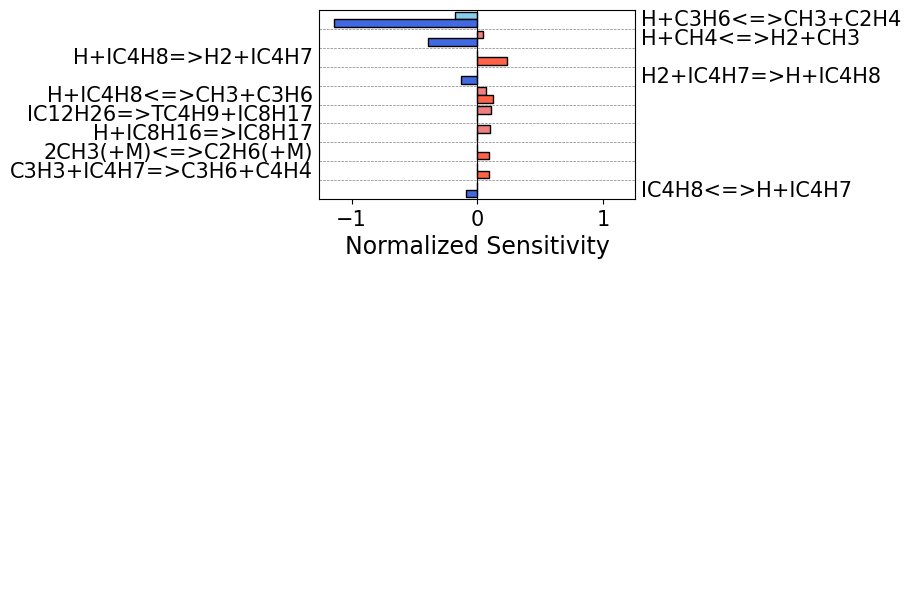

In [84]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

# === 반반 색 범례용 클래스 & 핸들러 ===
class SplitLegend(mpatches.Rectangle):
    def __init__(self, color_left="navy", color_right="firebrick"):
        super().__init__((0, 0), 1, 1, facecolor="none", edgecolor="black")
        self._color_left = color_left
        self._color_right = color_right

class HandlerSplit(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent,
                       width, height, fontsize, trans):
        cl = getattr(orig_handle, "_color_left", "gray")
        cr = getattr(orig_handle, "_color_right", "lightgray")
        left  = mpatches.Rectangle([xdescent, ydescent], width/2, height,
                                   transform=trans, facecolor=cl, edgecolor="black")
        right = mpatches.Rectangle([xdescent + width/2, ydescent], width/2, height,
                                   transform=trans, facecolor=cr, edgecolor="black")
        return [left, right]

# === 설정 ===
files = [
    "./data/PP_1773K_NOS_C3H6.csv",
    "./data/PP_2273K_NOS_C3H6.csv",
    "./data/PP_2773K_NOS_C3H6.csv",
]
top_n_per_temp = 10
final_max_reactions = 10
TARGET_COL = "Normalized Sensitivity"
label_limit = 35

# 온도별 색상 매핑
color_map = {
    "2773 K": {"pos": "firebrick",  "neg": "navy"},
    "2273 K": {"pos": "tomato",     "neg": "royalblue"},
    "1773 K": {"pos": "lightcoral", "neg": "skyblue"}
}

def pretty_temp_label(path):
    m = re.search(r'_(\d{4})K', os.path.basename(path))
    return f"{m.group(1)} K" if m else os.path.basename(path)

def _norm_key(s: str) -> str:
    return re.sub(r"[^a-z0-9]", "", s.lower())

def load_series(fp):
    df = pd.read_csv(fp)
    df.columns = [c.strip() for c in df.columns]
    if "Reaction" not in df.columns:
        raise KeyError(f"'Reaction' 열이 없음: {df.columns}")
    if TARGET_COL in df.columns:
        col = TARGET_COL
    else:
        want = _norm_key(TARGET_COL)
        cand = [c for c in df.columns if _norm_key(c) == want]
        if cand:
            col = cand[0]
        else:
            raise KeyError(f"'{TARGET_COL}' 열 없음")
    if top_n_per_temp is not None:
        pick_idx = df[col].abs().sort_values(ascending=False).head(top_n_per_temp).index
        df = df.loc[pick_idx]
    return df.set_index("Reaction")[col].astype(float)

# === 데이터 병합 ===
labels, series_list = [], []
for fp in files:
    if not os.path.exists(fp):
        print(f"⚠️ 파일 없음: {fp}, 건너뜁니다.")
        continue
    s = load_series(fp)
    series_list.append(s)
    labels.append(pretty_temp_label(fp))

if not series_list:
    raise RuntimeError("❌ 유효한 데이터 파일이 없습니다. 플롯을 생성할 수 없습니다.")

all_reactions = sorted(set().union(*[s.index for s in series_list]))
mat = pd.DataFrame(index=all_reactions, columns=labels, dtype=float)
for lab, s in zip(labels, series_list):
    mat.loc[s.index, lab] = s
mat = mat.fillna(0.0)
order = mat.abs().max(axis=1).sort_values(ascending=False).index
mat = mat.loc[order]
if final_max_reactions is not None:
    mat = mat.iloc[:final_max_reactions]

# === 라벨링 준비 ===
annotations, plot_tags = [], []
long_idx = 1
for r in mat.index:
    if len(r) > label_limit:
        tag = f"R{long_idx}"
        annotations.append(f"{tag}: {r}")
        plot_tags.append(tag)
        long_idx += 1
    else:
        plot_tags.append(r)

# === 플롯 ===
n_reac, n_temp = len(mat), len(labels)

# (A) 그래프 박스 비율 고정값(세로/가로) ← 여기만 바꿔도 비율 고정
AX_BOX_ASPECT = 0.6

# 반응식 수에 따라 세로 크기만 늘어나게(가로는 고정)
fig = plt.figure(constrained_layout=True, figsize=(9, max(9, 0.35 * n_reac)))  # ★ tight_layout 대신 constrained_layout
gs = fig.add_gridspec(2, 1, height_ratios=[10, 1])  # 위:아래 비율

ax1 = fig.add_subplot(gs[0])
ax1.set_box_aspect(AX_BOX_ASPECT)  # ★ 그래프(axes) 가로:세로 비율 고정

group_height = 0.8
bar_h = group_height / max(1, n_temp)  # 온도 개수와 무관하게 그룹 높이는 일정
y = np.arange(n_reac)

# 바 그리기
for i, lab in enumerate(labels):
    values = mat[lab].values
    y_off = (i - (n_temp - 1) / 2) * bar_h
    for j, val in enumerate(values):
        color = color_map.get(lab, {}).get("pos" if val >= 0 else "neg", "gray")
        ax1.barh(y[j] + y_off, val, height=bar_h, color=color, edgecolor="black")

# 축, 범위
ax1.set_yticks([])  # y축 라벨 제거
ax1.set_xlabel("Normalized Sensitivity", fontsize=17)
ax1.tick_params(axis='x', labelsize=15)
ax1.axvline(0, color='black', linewidth=0.8)

xmax = np.nanmax(np.abs(mat.values)) if mat.size else 1.0
ax1.set_xlim(-xmax * 1.1, xmax * 1.1)
ax1.invert_yaxis()

# === 라벨: 막대와 겹치지 않게, xlim은 그대로 유지하고 배치하려면 axes-좌표로 그려도 됨 ===
from matplotlib.transforms import blended_transform_factory
trans = blended_transform_factory(ax1.transAxes, ax1.transData)
x_left_ax, x_right_ax = -0.02, 1.02  # 축 바깥 여백(좌/우 2%) — 필요시 조절

for yi, (reaction, tag) in enumerate(zip(mat.index, plot_tags)):
    row = mat.loc[reaction]
    pos_max = row[row > 0].max() if (row > 0).any() else 0.0
    neg_min = row[row < 0].min() if (row < 0).any() else 0.0

    # 어느 쪽 공간이 더 여유로운지 판단(축 좌표에서)
    x_min, x_max = ax1.get_xlim()
    span = x_max - x_min
    pos_ax = (pos_max - x_min) / span
    neg_ax = (neg_min - x_min) / span
    space_left  = max(0.0, neg_ax - 0.0)
    space_right = max(0.0, 1.0 - pos_ax)

    if space_right >= space_left:
        ax1.text(x_right_ax, yi, tag, transform=trans,
                 ha="left", va="center", fontsize=15, color="black", clip_on=False)
    else:
        ax1.text(x_left_ax, yi, tag, transform=trans,
                 ha="right", va="center", fontsize=15, color="black", clip_on=False)

# 구분선(마지막 아래는 생략)
for i in range(n_reac - 1):
    ax1.axhline(i + 0.5, color="gray", linewidth=0.5, linestyle="--")

# y축 상/하 여백 제거
ax1.set_ylim(n_reac - 0.5, -0.5)

# === 주석 영역 ===
ax2 = fig.add_subplot(gs[1])
ax2.axis("off")
if annotations:
    ax2.text(0, 1, "\n".join(annotations), ha="left", va="top", fontsize=12, wrap=True)

# ★ tight_layout()은 쓰지 않습니다(박스비율 유지 위해).
# fig.savefig/plt.show
os.makedirs("./fig", exist_ok=True)
plt.savefig("./fig/Sensitivity_PP_C3H6.pdf", bbox_inches="tight")
plt.show()
